In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

## Sentiment Classification and finetuning

In [ ]:
# Import necessary library
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from tensorflow.keras.models import Model
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import (BertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification)
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification


In [ ]:
# Loading the data
df = pd.read_csv("/content/drive/MyDrive/FinalDatasetmerged (1) (1).csv").dropna()
df['sentiment_labels']=df['sentiment_labels'].replace(-1, 0)
df.head(10)

,content,sentiment_labels
0,feature search hotspot location able function ...,0.0
1,good,2.0
2,easy scan,2.0
3,good lindungi diri lindungi semua,2.0
4,Extremely happy with the experience. They deli...,2.0
5,fast efficient data processing excuse using,2.0
6,nice super get,2.0
7,bad,0.0
8,mom small kids writing workout schedule meal p...,2.0
9,genuine product,2.0


In [ ]:
df.shape

(32183, 2)

In [ ]:
df.isnull().sum()

content             0
sentiment_labels    0
dtype: int64

In [ ]:
X = list(df['content'])#Independent variable
y = list(df['sentiment_labels']) #Dependent variable

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_1, y_train, y_1 = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_1, y_1, test_size=0.5, random_state=42)

In [ ]:
#Load tokenizer to convert raw data into numeric
# from transformers import DistilBertTokenizerFast
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
##convert texts into numeric
train_encodings = tokenizer(X_train, truncation=True, padding=True)
eval_encodings = tokenizer(X_eval,truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
import tensorflow as tf
#Convert those encodings into data set object to feed the model
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
eval_dataset = tf.data.Dataset.from_tensor_slices((
    dict(eval_encodings),
    y_eval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='/content/drive/MyDrive/results1',# output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=10,
    eval_steps = 10
)

In [ ]:
with training_args.strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL,num_labels=3)

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset             # evaluation dataset
)

trainer.train()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/trainer_tf.py:118: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [ ]:
trainer.evaluate(eval_dataset)

{'eval_loss': 0.2058094326812442}

In [ ]:
predeval=trainer.predict(eval_dataset)[1]

In [ ]:
trainer.predict(test_dataset)[1]

array([2., 2., 0., ..., 1., 2., 0.], dtype=float32)

Confusion Matrix:
 [[ 989    0    0]
 [   0  507    0]
 [   0    0 1722]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       989
         1.0       1.00      1.00      1.00       507
         2.0       1.00      1.00      1.00      1722

    accuracy                           1.00      3218
   macro avg       1.00      1.00      1.00      3218
weighted avg       1.00      1.00      1.00      3218



<Axes: >

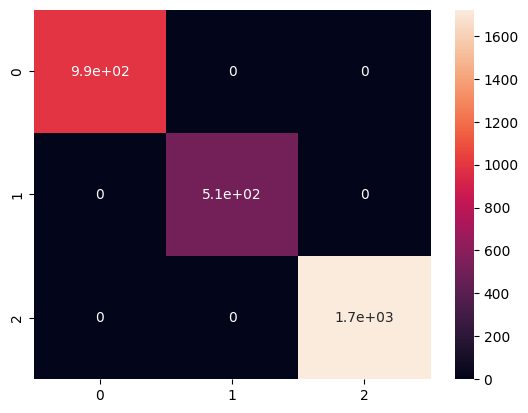

In [ ]:
from sklearn.metrics import classification_report,f1_score,confusion_matrix
import seaborn as sns
output=trainer.predict(test_dataset)[1]
#f1score = f1_score(y_test,output)
cm=confusion_matrix(y_test,output)
clsr=classification_report(y_test,output)
print(f'Confusion Matrix:\n {cm}\n=================================\nClassification Report: \n {clsr}')
sns.heatmap(cm, annot=True)

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/saved_model/NZapp_model')
trainer.save_model('/content/drive/MyDrive/saved_model/NZapp_model')
#trainer.save_model('CustomModel')

In [ ]:
!pip install huggingface_hub

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_model/NZapp_model")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/saved_model/NZapp_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("Rasith/NZappFineTune2") #user name

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]